# Import Libraries

In [32]:
#Keras
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.callbacks import EarlyStopping

#TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Dropout,Convolution2D,MaxPooling2D,Flatten, BatchNormalization
from tensorflow.keras import regularizers, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

#Pre-trained models
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121

#Sklearn
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold

#Others
import os
import shutil
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Data preparation

In [2]:
# Create new folder if not exists
def make_new_folder(folder_name, parent_folder):
    path = os.path.join(parent_folder, folder_name)
    if not os.path.exists(path):
        os.mkdir(path)
        print(folder_name[2:], ' folder created')

# Combine contents of given directories into a new folder
def combine(source_dirs, dest_dir):
    make_new_folder(dest_dir, os.getcwd())
    for source_dir in source_dirs:
        for content in os.listdir(source_dir):
            if not content.startswith('.'):
                src_path = os.path.join(source_dir, content)
                dst_path = os.path.join(dest_dir, content)
                shutil.move(src_path, dst_path)
    print('Combine Successful')

# Balance number of files in two directories by randomly selecting files to move
def balance_files(src_dir, dest_dir, count):
    make_new_folder(dest_dir, os.getcwd())
    files = os.listdir(src_dir)
    for file in random.sample(files, count):
        src_path = os.path.join(src_dir, file)
        dst_path = os.path.join(dest_dir, file)
        shutil.move(src_path, dst_path)
    print('Balance Successful')

# Create validation, test, and train directories and move files to them
def split_data(src_dir, dest_train_dir, dest_val_dir, dest_test_dir):
    count = min([len(os.listdir(src_dir)), 1000])
    balance_files(src_dir, dest_val_dir, int(count * 0.2))
    balance_files(src_dir, dest_test_dir, int(count * 0.15))
    balance_files(src_dir, dest_train_dir, int(count * 0.65))
    print('Split Successful')

# Define source and destination directories
pneu_dirs = ['./chest_xray/val/PNEUMONIA', './chest_xray/train/PNEUMONIA',
             './chest_xray/test/PNEUMONIA']
norm_dirs = ['./chest_xray/val/NORMAL', './chest_xray/train/NORMAL',
             './chest_xray/test/NORMAL']
pneu_dest = './PNEUMONIA'
norm_dest = './NORMAL'
train_dir = './chest_xray/train'
val_dir = './chest_xray/val'
test_dir = './chest_xray/test'

# Combine and balance pneumonia and normal directories
combine(pneu_dirs, pneu_dest)
combine(norm_dirs, norm_dest)
pneu_count = len(os.listdir(pneu_dest))
norm_count = len(os.listdir(norm_dest))
balanced_count = min(pneu_count, norm_count)
balance_files(pneu_dest, os.path.join(train_dir, 'PNEUMONIA'), balanced_count)
balance_files(norm_dest, os.path.join(train_dir, 'NORMAL'), balanced_count)

# Split train data into train, val, and test directories
split_data(os.path.join(train_dir, 'PNEUMONIA'),
           os.path.join(train_dir, 'PNEUMONIA'),
           os.path.join(val_dir, 'PNEUMONIA'),
           os.path.join(test_dir, 'PNEUMONIA'))

split_data(os.path.join(train_dir, 'NORMAL'),
           os.path.join(train_dir, 'NORMAL'),
           os.path.join(val_dir, 'NORMAL'),
           os.path.join(test_dir, 'NORMAL'))

#Remove all created folders
folders = ['./NORMAL', './PNEUMONIA']

for folder in folders:
    try:
        shutil.rmtree(folder)
        print(f"{folder[2:]} removed successfully")
    except:
        print(f"{folder[2:]} does not exist")


PNEUMONIA  folder created
Combine Successful
NORMAL  folder created
Combine Successful
Balance Successful
Balance Successful
Balance Successful
Balance Successful
Balance Successful
Split Successful
Balance Successful
Balance Successful
Balance Successful
Split Successful
NORMAL removed successfully
PNEUMONIA removed successfully


# Data argumentation and import

### Train data

In [3]:
IMAGE_SIZE = 128

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=0.05,
        zoom_range=0.05,
        brightness_range=(0.8, 1.2),
        horizontal_flip=True
        
)

train_generator = train_datagen.flow_from_directory(
        './chest_xray/train',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        class_mode="sparse",
        batch_size=32
)

Found 2466 images belonging to 2 classes.


### Validation data

In [4]:
validation_datagen = ImageDataGenerator(
#         rescale=1./255,
#         rotation_range=0,
#         horizontal_flip=True,
        rescale=1./255,
        rotation_range=0.05,
        zoom_range=0.05,
        brightness_range=(0.8, 1.2),
        horizontal_flip=True
        
)

validation_generator = validation_datagen.flow_from_directory(
        './chest_xray/val',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        class_mode="sparse",
        batch_size=32
)

Found 400 images belonging to 2 classes.


### Test data

In [5]:
test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=0.05,
        zoom_range=0.05,
        brightness_range=(0.8, 1.2),
        horizontal_flip=True
)

test_dir = './chest_xray/test'
num_test_images = len(os.listdir(os.path.join(test_dir, 'NORMAL'))) + len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
batch_size = num_test_images

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        class_mode="sparse",
        batch_size=batch_size,
        shuffle=True
)

Found 300 images belonging to 2 classes.


# Automatic Hyper-Parameter Tuning

In [6]:
# Define model builder function
def build_model_vgg19(hp):
    # Load pre-trained VGG19 model
    vgg_model = keras.applications.VGG19(include_top=False, weights='imagenet',
                                         input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    # Freeze pre-trained layers
    for layer in vgg_model.layers:
        layer.trainable = False
    
    #Add custom classification layers
    custom_layer = vgg_model.output
    custom_layer = layers.Flatten()(custom_layer)
    custom_layer = layers.Dense(units=hp.Int('dense_units_1',
                                             min_value=128,
                                             max_value=1024,
                                             step=64,
                                             default=128), activation='relu')(custom_layer)
    
    custom_layer = layers.Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5,
                                           step=0.1, default=0.2))(custom_layer)
    
    custom_layer = layers.Dense(units=hp.Int('dense_units_2',
                                             min_value=128,
                                             max_value=1024,
                                             step=64,
                                             default=128), activation='relu')(custom_layer)
    
    custom_layer = layers.Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5,
                                           step=0.1, default=0.2))(custom_layer)
    
    output = Dense(2, activation='softmax')(custom_layer)
    
    #Define model
    vgg19_model = Model(inputs = vgg_model.inputs, outputs = output)
    
    # Compile model
    vgg19_model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-5,
                                                 max_value=1e-3, sampling='log')),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'])

    return vgg19_model

def build_model_resnet50(hp):
    # Load pre-trained ResNet50 model
    resnet_model = keras.applications.ResNet50(include_top=False, weights='imagenet',
                                               input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    # Freeze pre-trained layers
    for layer in resnet_model.layers:
        layer.trainable = False
    
    #Add custom classification layers
    custom_layer = resnet_model.output
    custom_layer = layers.Flatten()(custom_layer)
    custom_layer = layers.Dense(units=hp.Int('dense_units_1',
                                             min_value=128,
                                             max_value=1024,
                                             step=64,
                                             default=128), activation='relu')(custom_layer)
    
    custom_layer = layers.Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5,
                                           step=0.1, default=0.2))(custom_layer)
    
    custom_layer = layers.Dense(units=hp.Int('dense_units_2',
                                             min_value=128,
                                             max_value=1024,
                                             step=64,
                                             default=128), activation='relu')(custom_layer)
    
    custom_layer = layers.Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5,
                                           step=0.1, default=0.2))(custom_layer)
    
    output = Dense(2, activation='softmax')(custom_layer)
    
    #Define model
    resnet50_model = Model(inputs = resnet_model.inputs, outputs = output)
    
    # Compile model
    resnet50_model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-5,
                                                 max_value=1e-3, sampling='log')),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'])

    return resnet50_model

def build_model_densenet121(hp):
    # Load pre-trained DenseNet121 model
    densenet_model = keras.applications.DenseNet121(include_top=False, weights='imagenet',
                                                    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    # Freeze pre-trained layers
    for layer in densenet_model.layers:
        layer.trainable = False
    
    #Add custom classification layers
    custom_layer = densenet_model.output
    custom_layer = layers.Flatten()(custom_layer)
    custom_layer = layers.Dense(units=hp.Int('dense_units_1',
                                             min_value=128,
                                             max_value=1024,
                                             step=64,
                                             default=128), activation='relu')(custom_layer)
    
    custom_layer = layers.Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5,
                                           step=0.1, default=0.2))(custom_layer)
    
    custom_layer = layers.Dense(units=hp.Int('dense_units_2',
                                             min_value=128,
                                             max_value=1024,
                                             step=64,
                                             default=128), activation='relu')(custom_layer)
    
    custom_layer = layers.Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5,
                                           step=0.1, default=0.2))(custom_layer)
    
    output = Dense(2, activation='softmax')(custom_layer)
    
    #Define model
    densenet121_model = Model(inputs = densenet_model.inputs, outputs = output)
    
    # Compile model
    densenet121_model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-5,
                                                 max_value=1e-3, sampling='log')),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'])

    return densenet121_model
        

In [7]:
# Define tuner for all three models
tuner_vgg19 = RandomSearch(
    build_model_vgg19,
    objective='val_accuracy',
    max_trials=20,
    directory='tuner_vgg19',
    project_name='pneumonia_tuner')

tuner_resnet50 = RandomSearch(
    build_model_resnet50,
    objective='val_accuracy',
    max_trials=20,
    directory='tuner_resnet50',
    project_name='pneumonia_tuner')

tuner_densenet121 = RandomSearch(
    build_model_densenet121,
    objective='val_accuracy',
    max_trials=20,
    directory='tuner_densenet121',
    project_name='pneumonia_tuner')

# Search for best hyperparameters for all models
tuner_vgg19.search(train_generator,
                   epochs=5,
                   validation_data=validation_generator,
                   steps_per_epoch=len(train_generator),
                   validation_steps=len(validation_generator))

tuner_resnet50.search(train_generator,
                      epochs=5,
                      validation_data=validation_generator,
                      steps_per_epoch=len(train_generator),
                      validation_steps=len(validation_generator))

tuner_densenet121.search(train_generator,
                         epochs=5,
                         validation_data=validation_generator,
                         steps_per_epoch=len(train_generator),
                         validation_steps=len(validation_generator))

# Get best models and hyperparameters for all models
best_models = [tuner_vgg19.get_best_models(num_models=1)[0],
               tuner_resnet50.get_best_models(num_models=1)[0],
               tuner_densenet121.get_best_models(num_models=1)[0]]

best_hps = [tuner_vgg19.get_best_hyperparameters(num_trials=1)[0],
            tuner_resnet50.get_best_hyperparameters(num_trials=1)[0],
            tuner_densenet121.get_best_hyperparameters(num_trials=1)[0]]

# Print the best hyperparameters and test accuracy for all models
model_names = ['VGG19', 'ResNet50', 'DenseNet121']

for i in range(len(model_names)):
    print(f"\nBest set of hyperparameters for {model_names[i]} model:")
    for hp, value in best_hps[i].values.items():
        print(f"{hp}: {value}")
    #print("\n")
    
    # Evaluate best model on test data
#     loss, accuracy = best_models[i].evaluate(test_generator, steps=len(test_generator),verbose=3)
#     print('*========================*')
#     print(f'Test accuracy for {model_names[i]} model: %.2f%%' % (accuracy * 100))
#     print(f'Test loss for {model_names[i]} model: %.3f' % (loss))
#     print('*========================*')


Metal device set to: Apple M1

Best set of hyperparameters for VGG19 model:
dense_units_1: 832
dropout_1: 0.2
dense_units_2: 768
dropout_2: 0.5
learning_rate: 0.00038526189573804745

Best set of hyperparameters for ResNet50 model:
dense_units_1: 576
dropout_1: 0.2
dense_units_2: 704
dropout_2: 0.30000000000000004
learning_rate: 0.00025920774988024233

Best set of hyperparameters for DenseNet121 model:
dense_units_1: 320
dropout_1: 0.30000000000000004
dense_units_2: 128
dropout_2: 0.2
learning_rate: 3.128425383189363e-05


# Model Implementation

## Baseline

## VGG19 + transfer learning

In [8]:
# Load VGG19 base model without the top layer
vgg_model = VGG19(include_top=False, weights = 'imagenet', input_shape=(128, 128, 3))

# Freeze base model layers
for layer in vgg_model.layers:
    layer.trainable=False
    
# Add custom layers
vgg_custom_layer = vgg_model.output
vgg_custom_layer = Flatten()(vgg_custom_layer)
vgg_custom_layer = Dense(832, activation='relu')(vgg_custom_layer)
vgg_custom_layer = Dropout(0.2)(vgg_custom_layer)
vgg_custom_layer = Dense(768, activation='relu')(vgg_custom_layer)
vgg_custom_layer = Dropout(0.5)(vgg_custom_layer)
vgg_output = Dense(2, activation='softmax')(vgg_custom_layer)

vgg19_model = Model(inputs = vgg_model.inputs, outputs = vgg_output)

In [9]:
vgg19_model.compile(optimizer=Adam(learning_rate=0.00038526189573804745),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [10]:
vgg19_early_stopping_monitor = EarlyStopping(patience=3,
                                       monitor='val_loss',
                                       restore_best_weights = True,
                                       mode='min',
                                       verbose=1)

In [11]:
EPOCHS = 20
history_vgg19 = vgg19_model.fit(
    train_generator,
    #steps_per_epoch=20,
    validation_data=validation_generator,
    epochs=EPOCHS,
    #validation_steps=100,
    #class_weight=class_weights,
    callbacks=[vgg19_early_stopping_monitor]
)

Epoch 1/20
78/78 [==============================] - 28s 353ms/step - loss: 0.3699 - accuracy: 0.8447 - val_loss: 0.1741 - val_accuracy: 0.9325
Epoch 2/20
78/78 [==============================] - 26s 334ms/step - loss: 0.2156 - accuracy: 0.9193 - val_loss: 0.1741 - val_accuracy: 0.9325
Epoch 3/20
78/78 [==============================] - 26s 332ms/step - loss: 0.1790 - accuracy: 0.9323 - val_loss: 0.1382 - val_accuracy: 0.9550
Epoch 4/20
78/78 [==============================] - 26s 332ms/step - loss: 0.1842 - accuracy: 0.9238 - val_loss: 0.1293 - val_accuracy: 0.9575
Epoch 5/20
78/78 [==============================] - 26s 332ms/step - loss: 0.1549 - accuracy: 0.9416 - val_loss: 0.1534 - val_accuracy: 0.9550
Epoch 6/20
78/78 [==============================] - 26s 333ms/step - loss: 0.1437 - accuracy: 0.9465 - val_loss: 0.1276 - val_accuracy: 0.9575
Epoch 7/20
78/78 [==============================] - 26s 332ms/step - loss: 0.1446 - accuracy: 0.9448 - val_loss: 0.1422 - val_accuracy: 0.9550

In [12]:
test_acc_vgg19 = vgg19_model.evaluate(test_generator,verbose=3)
print('Loss in Test set:      %.02f' % (test_acc_vgg19[0]))
print('Accuracy on Test set:  %.02f' % (test_acc_vgg19[1] * 100)+'%')

Loss in Test set:      0.19
Accuracy on Test set:  92.00%


## ResNet50 + transfer learning

In [13]:
# Load ResNet50 base model without the top layer
resnet_model = ResNet50(weights='imagenet', include_top=False,
                        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze base model layers
for layer in resnet_model.layers:
    layer.trainable = False

# Add custom layers
rn_custom_layer = resnet_model.output
rn_custom_layer = tf.keras.layers.Flatten()(rn_custom_layer)
rn_custom_layer = tf.keras.layers.Dense(576, activation='relu')(rn_custom_layer)
rn_custom_layer = tf.keras.layers.Dropout(0.2)(rn_custom_layer)
rn_custom_layer = tf.keras.layers.Dense(704, activation='relu')(rn_custom_layer)
rn_custom_layer = tf.keras.layers.Dropout(0.3)(rn_custom_layer)
rn_output = tf.keras.layers.Dense(2, activation='softmax')(rn_custom_layer)

# Compile model
resnet50_model = tf.keras.models.Model(inputs=resnet_model.input, outputs=rn_output)

In [14]:
resnet50_model.compile(optimizer=Adam(learning_rate=0.00025920774988024233),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [15]:
resnet50_early_stopping_monitor = EarlyStopping(patience=3,
                                       monitor='val_loss',
                                       restore_best_weights = True,
                                       mode='min',
                                       verbose=1)

In [16]:
EPOCHS = 20
history_resnet50 = resnet50_model.fit(
    train_generator,
    #steps_per_epoch=20,
    validation_data=validation_generator,
    epochs=EPOCHS,
    #validation_steps=100,
    #class_weight=class_weights,
    callbacks=[resnet50_early_stopping_monitor]
)

Epoch 1/20
78/78 [==============================] - 31s 370ms/step - loss: 0.6950 - accuracy: 0.6014 - val_loss: 0.5203 - val_accuracy: 0.7800
Epoch 2/20
78/78 [==============================] - 26s 328ms/step - loss: 0.5421 - accuracy: 0.7295 - val_loss: 0.4416 - val_accuracy: 0.8050
Epoch 3/20
78/78 [==============================] - 26s 337ms/step - loss: 0.4225 - accuracy: 0.8078 - val_loss: 0.3385 - val_accuracy: 0.8525
Epoch 4/20
78/78 [==============================] - 25s 321ms/step - loss: 0.4593 - accuracy: 0.7810 - val_loss: 0.5996 - val_accuracy: 0.6750
Epoch 5/20
78/78 [==============================] - 25s 321ms/step - loss: 0.3654 - accuracy: 0.8402 - val_loss: 0.3513 - val_accuracy: 0.8600
Epoch 6/20
78/78 [==============================] - 25s 324ms/step - loss: 0.3981 - accuracy: 0.8151 - val_loss: 0.2916 - val_accuracy: 0.8750
Epoch 7/20
78/78 [==============================] - 25s 325ms/step - loss: 0.3244 - accuracy: 0.8633 - val_loss: 0.2635 - val_accuracy: 0.9000

In [17]:
test_acc_resnet = resnet50_model.evaluate(test_generator,verbose=3)
print('Loss in Test set:      %.02f' % (test_acc_resnet[0]))
print('Accuracy on Test set:  %.02f' % (test_acc_resnet[1] * 100)+'%')

Loss in Test set:      0.29
Accuracy on Test set:  87.67%


## DenseNet121 + transfer learning

In [18]:
# Load DenseNet121 base model without the top layer
densenet_model = DenseNet121(weights='imagenet', include_top=False,
                             input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze base model layers
for layer in densenet_model.layers:
    layer.trainable = False

# Add custom layers
dn_custom_layer = densenet_model.output
dn_custom_layer = tf.keras.layers.Flatten()(dn_custom_layer)
dn_custom_layer = tf.keras.layers.Dense(320, activation='relu')(dn_custom_layer)
dn_custom_layer = tf.keras.layers.Dropout(0.3)(dn_custom_layer)
dn_custom_layer = tf.keras.layers.Dense(128, activation='relu')(dn_custom_layer)
dn_custom_layer = tf.keras.layers.Dropout(0.2)(dn_custom_layer)
dn_output = tf.keras.layers.Dense(2, activation='softmax')(dn_custom_layer)

# Compile model
densenet121_model = tf.keras.models.Model(inputs=densenet_model.input, outputs=dn_output)


In [19]:
densenet121_model.compile(optimizer=Adam(learning_rate=3.128425383189363e-05),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [20]:
densenet121_early_stopping_monitor = EarlyStopping(patience=3,
                                       monitor='val_loss',
                                       restore_best_weights = True,
                                       mode='min',
                                       verbose=1)

In [21]:
EPOCHS = 20
history_densenet121 = densenet121_model.fit(
    train_generator,
    #steps_per_epoch=20,
    validation_data=validation_generator,
    epochs=EPOCHS,
    #validation_steps=100,
    #class_weight=class_weights,
    callbacks=[densenet121_early_stopping_monitor]
)

Epoch 1/20
78/78 [==============================] - 33s 376ms/step - loss: 0.4074 - accuracy: 0.8370 - val_loss: 0.2264 - val_accuracy: 0.9075
Epoch 2/20
78/78 [==============================] - 26s 325ms/step - loss: 0.2155 - accuracy: 0.9144 - val_loss: 0.1597 - val_accuracy: 0.9475
Epoch 3/20
78/78 [==============================] - 25s 323ms/step - loss: 0.1787 - accuracy: 0.9363 - val_loss: 0.1749 - val_accuracy: 0.9325
Epoch 4/20
78/78 [==============================] - 26s 325ms/step - loss: 0.1874 - accuracy: 0.9343 - val_loss: 0.1578 - val_accuracy: 0.9450
Epoch 5/20
78/78 [==============================] - 26s 336ms/step - loss: 0.1815 - accuracy: 0.9307 - val_loss: 0.1503 - val_accuracy: 0.9450
Epoch 6/20
78/78 [==============================] - 26s 331ms/step - loss: 0.1524 - accuracy: 0.9404 - val_loss: 0.1439 - val_accuracy: 0.9525
Epoch 7/20
78/78 [==============================] - 25s 324ms/step - loss: 0.1453 - accuracy: 0.9477 - val_loss: 0.1751 - val_accuracy: 0.9325

In [22]:
test_acc_densenet = densenet121_model.evaluate(test_generator,verbose=3)
print('Loss in Test set:      %.02f' % (test_acc_densenet[0]))
print('Accuracy on Test set:  %.02f' % (test_acc_densenet[1] * 100)+'%')

Loss in Test set:      0.17
Accuracy on Test set:  93.67%


# Evaluation Of Models

## Helper Codes 

In [23]:
class_names = list(train_generator.class_indices.keys())

def plot_graph(early_stopping, history_):
    if (early_stopping.stopped_epoch == 0):
        EPOCHS=EPOCHS
    else:
        EPOCHS=(early_stopping.stopped_epoch+1)
    #print('Total EPOCHS is: ' + str(EPOCHS))
    
    acc = history_.history['accuracy']
    val_acc = history_.history['val_accuracy']

    loss = history_.history['loss']
    val_loss = history_.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(EPOCHS), acc, label='Training Accuracy')
    plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlim(0, EPOCHS)  # modify x axis limits
    plt.ylim(0, 1)  # modify y axis limits

    plt.subplot(1, 2, 2)
    plt.plot(range(EPOCHS), loss, label='Training Loss')
    plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlim(0, EPOCHS)  # modify x axis limits
    plt.ylim(0, 1)  # modify y axis limits
    plt.show()
    
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array,verbose=3)
    
    normal= predictions[0][0]*100
    pneumonia= predictions[0][1]*100
    
    #For testing purpose
#     norm_percent='Normal: {:.2f}%'.format(normal)
#     pneu_percent='Pneumonia: {:.2f}%'.format(pneumonia)
    
#     print('*=============*')
#     print(norm_percent)
#     print(pneu_percent)
    
    if normal>pneumonia:
        confidence = normal
        predicted_class=0
    else:
        confidence = pneumonia
        predicted_class=1
    

    predicted_class = class_names[predicted_class]
    return predicted_class, confidence

    
def class_report(ls_true, ls_pred, early_stopping, history_):
    plot_graph(early_stopping, history_)
    pred = np.array(ls_pred)
    y_true=np.array(ls_true)
    class_dict = {0: class_names[0],
               1: class_names[1],
               }

    cr=classification_report(y_true, pred, target_names=class_dict.values())
    print('#'+'='*60+'#')
    print(cr)
    auc(y_true, pred)
    matrix_plot(y_true, pred, class_dict)

def auc(y_true, pred):
    auc = roc_auc_score(y_true, pred)
    print('#'+'='*60+'#')
    print('The AUC is: ' +str(int(round(auc,2)*100))+'%')
    
def matrix_plot(y_true, pred, class_dict):
    print('#'+'='*60+'#')
    CM = confusion_matrix(y_true, pred)

    fig, ax = plt.subplots()
    im = ax.imshow(CM, cmap='summer')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_dict.values())))
    ax.set_yticks(np.arange(len(class_dict.values())))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_dict.values())
    ax.set_yticklabels(class_dict.values())

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_dict.values())):
        for j in range(len(class_dict.values())):
            text = ax.text(j, i, CM[i, j],
                           ha="center", va="center", color="black")

    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    fig.tight_layout()
    plt.show()
    

## VGG19

In [24]:
ls_pred=[]
ls_true=[]
for images, labels in test_generator:
    for i in range(num_test_images): 
        predicted_class, confidence = predict(vgg19_model, images[i])
        actual_class_num = int(labels[i])
        actual_class = class_names[actual_class_num]

        if predicted_class=='PNEUMONIA':
            predicted_class_num=1
        else:
            predicted_class_num=0

        ls_pred.append(predicted_class_num)
        ls_true.append(actual_class_num)

    break
print('Sucessfully classified '+ str(num_test_images)+ ' images using VGG19')

Sucessfully classified 300 images using VGG19


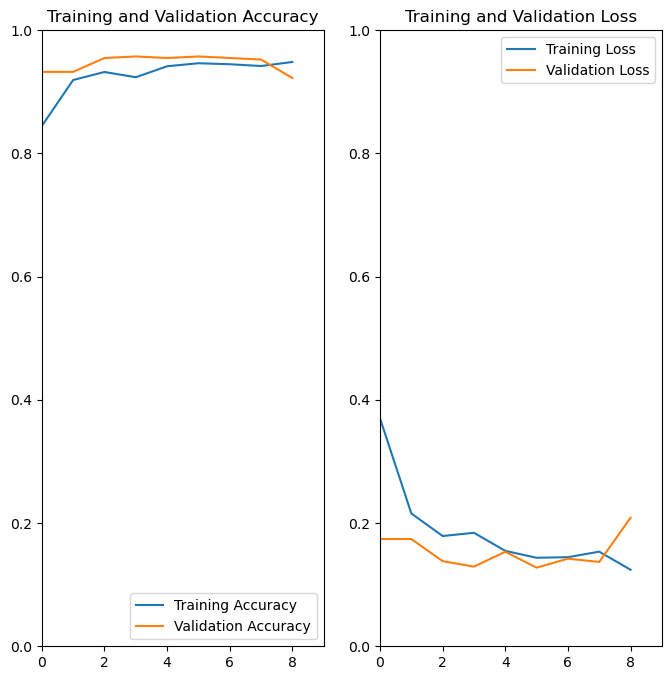

#============================================================#
              precision    recall  f1-score   support

      NORMAL       0.92      0.95      0.93       150
   PNEUMONIA       0.95      0.91      0.93       150

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300

#============================================================#
The AUC is: 93%
#============================================================#


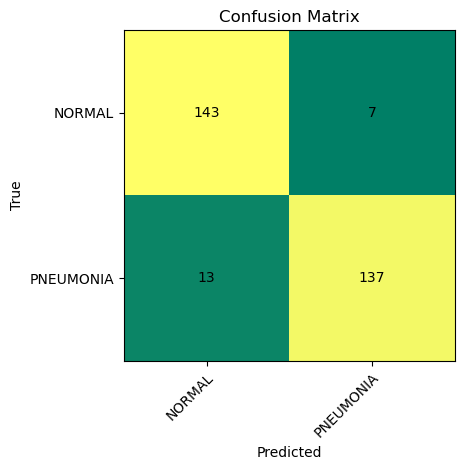

In [25]:
class_report(ls_true, ls_pred, vgg19_early_stopping_monitor, history_vgg19)

## ResNet50

In [26]:
ls_pred=[]
ls_true=[]
for images, labels in test_generator:
    for i in range(num_test_images): 
        predicted_class, confidence = predict(resnet50_model, images[i])
        actual_class_num = int(labels[i])
        actual_class = class_names[actual_class_num]

        if predicted_class=='PNEUMONIA':
            predicted_class_num=1
        else:
            predicted_class_num=0

        ls_pred.append(predicted_class_num)
        ls_true.append(actual_class_num)

    break
print('Sucessfully classified '+ str(num_test_images)+ ' images using ResNet50')

Sucessfully classified 300 images using ResNet50


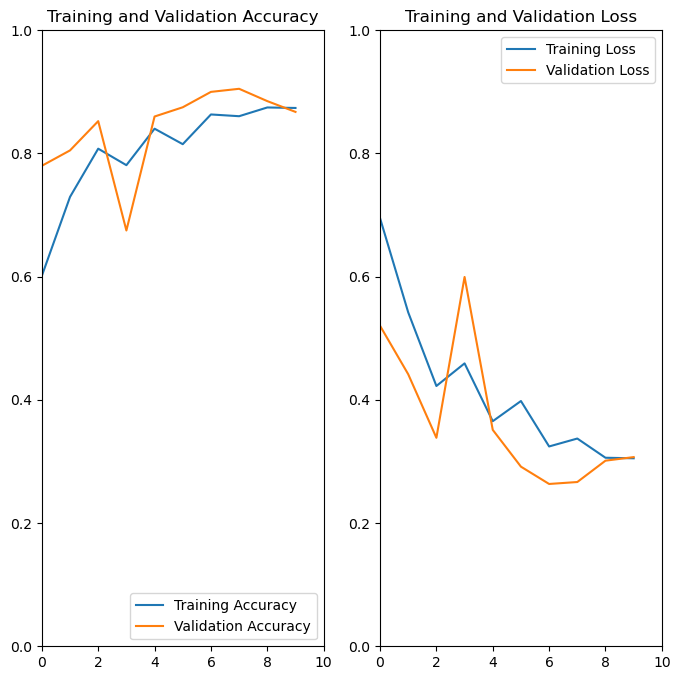

#============================================================#
              precision    recall  f1-score   support

      NORMAL       0.87      0.91      0.89       150
   PNEUMONIA       0.90      0.86      0.88       150

    accuracy                           0.88       300
   macro avg       0.88      0.88      0.88       300
weighted avg       0.88      0.88      0.88       300

#============================================================#
The AUC is: 88%
#============================================================#


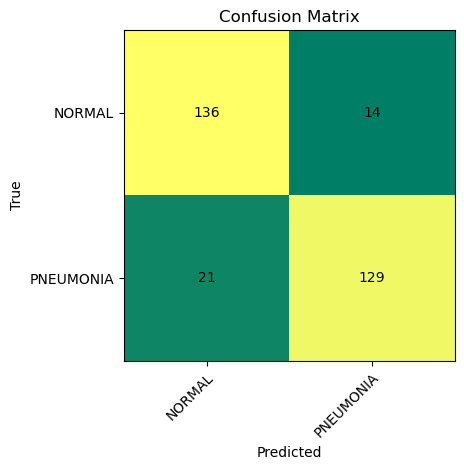

In [27]:
class_report(ls_true, ls_pred, resnet50_early_stopping_monitor, history_resnet50)

## DenseNet121

In [28]:
ls_pred=[]
ls_true=[]
for images, labels in test_generator:
    for i in range(num_test_images): 
        predicted_class, confidence = predict(densenet121_model, images[i])
        actual_class_num = int(labels[i])
        actual_class = class_names[actual_class_num]

        if predicted_class=='PNEUMONIA':
            predicted_class_num=1
        else:
            predicted_class_num=0

        ls_pred.append(predicted_class_num)
        ls_true.append(actual_class_num)

    break
print('Sucessfully classified '+ str(num_test_images)+ ' images using DenseNet121')

Sucessfully classified 300 images using DenseNet121


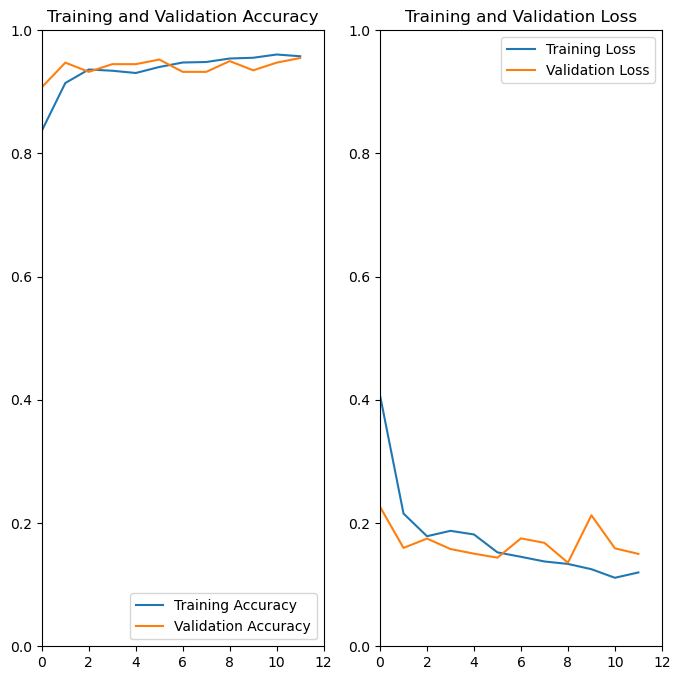

#============================================================#
              precision    recall  f1-score   support

      NORMAL       0.95      0.95      0.95       150
   PNEUMONIA       0.95      0.95      0.95       150

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300

#============================================================#
The AUC is: 95%
#============================================================#


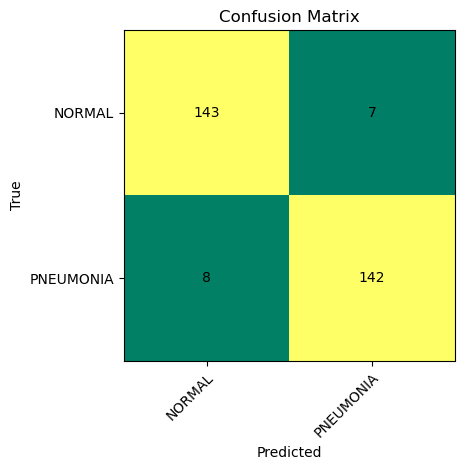

In [29]:
class_report(ls_true, ls_pred, densenet121_early_stopping_monitor, history_densenet121)

## Visual Evaluation on best model

Legend: 
A - Actual Result 
P - Predicted Result 
C - Confidence in result
Report: 
Test error rate: 2.78% - 1/36 wrong 
Correct:35


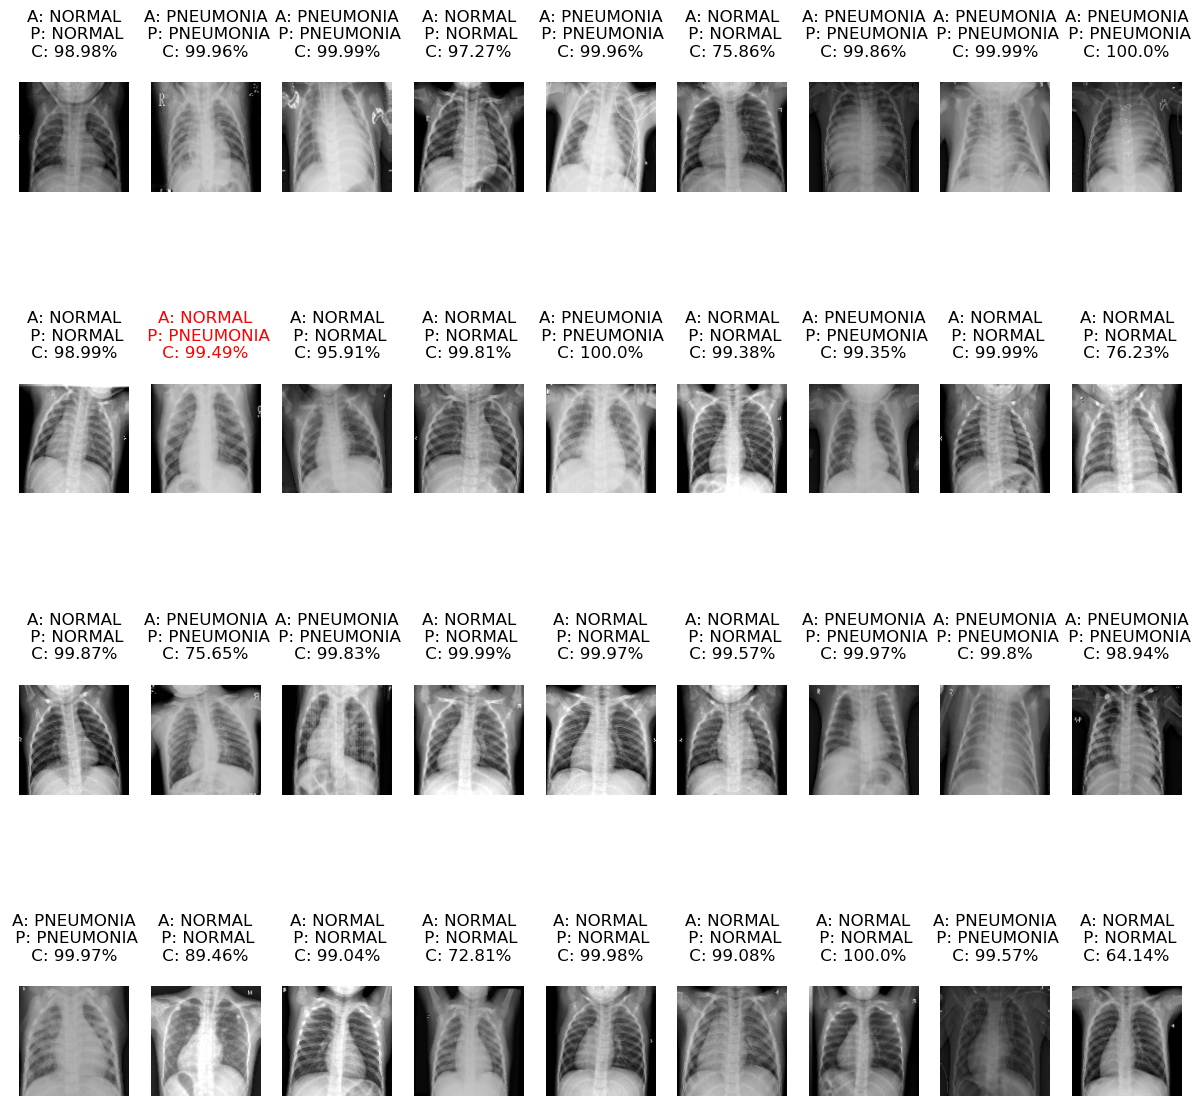

In [30]:
plt.figure(figsize=(15, 15))
err_count=0
doc_count=0
cor_count=0
ls_pred=[]
ls_true=[]
for images, labels in test_generator:
    for i in range(36):    
        ax = plt.subplot(4, 9, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(densenet121_model, images[i])
        actual_class_num = int(labels[i])
        actual_class = class_names[actual_class_num]
        

        if (actual_class!=predicted_class):
            err_count+=1
            clr='red'
            
        else:
            cor_count+=1
            clr='black'
            
        
        plt.title(f"A: {actual_class}\n P: {predicted_class}\n C: {round(confidence,2)}% \n",color=clr)
        plt.axis("off")

    break

print('Legend: \nA - Actual Result \nP - Predicted Result \nC - Confidence in result')
err_rate = round((err_count/(err_count+cor_count))*100,2)
print('Report: \nTest error rate: '
      +str(err_rate)+'% - '
      +str(err_count)+'/' 
      +str(err_count+cor_count)
      + ' wrong \nCorrect:'
      +str(cor_count))



## Iterated K-fold validation

In [37]:
EPOCHS=5

# Define the number of folds for cross-validation
n_splits = 5

# Define the number of iterations for iterated cross-validation
n_repeats = 5

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Create lists to store results for each iteration
accs = []
val_accs = []
losses = []
val_losses = []
test_accs = []
test_losses = []

# Iterate over the number of repeats
for i in range(n_repeats):
    print(f"Iteration {i+1}/{n_repeats}")
    
    # Iterate over the number of folds
    for j, (train_idx, val_idx) in enumerate(cv.split(train_generator.filenames, train_generator.classes)):
        print(f"Fold {j+1}/{n_splits}")
        
        # Define the model architecture
        densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

        # Freeze base model layers
        for layer in densenet_model.layers:
            layer.trainable = False

        # Add custom layers
        dn_custom_layer = densenet_model.output
        dn_custom_layer = tf.keras.layers.Flatten()(dn_custom_layer)
        dn_custom_layer = tf.keras.layers.Dense(320, activation='relu')(dn_custom_layer)
        dn_custom_layer = tf.keras.layers.Dropout(0.3)(dn_custom_layer)
        dn_custom_layer = tf.keras.layers.Dense(128, activation='relu')(dn_custom_layer)
        dn_custom_layer = tf.keras.layers.Dropout(0.2)(dn_custom_layer)
        dn_output = tf.keras.layers.Dense(2, activation='softmax')(dn_custom_layer)

        # Compile model
        densenet121_model = tf.keras.models.Model(inputs=densenet_model.input, outputs=dn_output)
        
        
        # Compile the model
        densenet121_model.compile(optimizer=Adam(learning_rate=3.128425383189363e-05),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
        
        # Train the model on the train and validation sets using the image generators
        history_densenet121 = densenet121_model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=EPOCHS,
            callbacks=[densenet121_early_stopping_monitor]
        )
        
        # Evaluate the model on the validation set
        val_loss, val_acc = densenet121_model.evaluate(validation_generator)
        #print(f"Validation loss: {val_loss:.3f}, Validation accuracy: {val_acc:.3f}")
        print('\nValidation accuracy: %.2f%%' % (val_acc * 100))
        print('Validation loss: %.3f\n' % (val_loss ))
        
        # Append the results to the lists
        accs.append(history_densenet121.history['accuracy'])
        val_accs.append(history_densenet121.history['val_accuracy'])
        losses.append(history_densenet121.history['loss'])
        val_losses.append(history_densenet121.history['val_loss'])
        
    # Evaluate the model on the test set using the image generator
    test_loss, test_acc = densenet121_model.evaluate(test_generator)
    test_accs.append(test_acc)
    test_losses.append(test_loss)
    #print(f"Test loss: {test_loss:.3f}, Test accuracy: {test_acc:.3f}")
    print('Test accuracy: %.2f%%' % (test_acc * 100))
    print('Test loss: %.3f\n' % (test_loss ))
    
# Compute the mean and standard deviation of the test accuracy over all iterations
mean_test_acc = np.mean(test_accs)
std_test_acc = np.std(test_accs)
mean_test_loss = np.mean(test_losses)
print('\nMean test accuracy: %.2f%%' % (mean_test_acc * 100))
print('Mean test loss: %.2f' % (mean_test_loss ))
print('Std test accuracy: %.3f' % (std_test_acc ))

# Calculate the mean of the training and validation accuracy and loss over all folds and iterations
train_acc_mean = np.mean(accs)
val_acc_mean = np.mean(val_accs)
train_loss_mean = np.mean(losses)
val_loss_mean = np.mean(val_losses)
print('\nMean training accuracy: %.2f%%' % (train_acc_mean * 100))
print('Mean training loss: %.3f' % (train_loss_mean ))

print('\nMean validation accuracy: %.2f%%' % (val_acc_mean * 100))
print('Mean validation loss: %.3f' % (val_loss_mean ))

Iteration 1/5
Fold 1/5
Epoch 1/5
78/78 [==============================] - 39s 422ms/step - loss: 0.4238 - accuracy: 0.8228 - val_loss: 0.2073 - val_accuracy: 0.9100
Epoch 2/5
78/78 [==============================] - 26s 327ms/step - loss: 0.2225 - accuracy: 0.9161 - val_loss: 0.1765 - val_accuracy: 0.9350
Epoch 3/5
78/78 [==============================] - 26s 330ms/step - loss: 0.2008 - accuracy: 0.9234 - val_loss: 0.1656 - val_accuracy: 0.9325
Epoch 4/5
78/78 [==============================] - 26s 325ms/step - loss: 0.1778 - accuracy: 0.9303 - val_loss: 0.1666 - val_accuracy: 0.9475
Epoch 5/5
13/13 [==============================] - 3s 260ms/step - loss: 0.1549 - accuracy: 0.9475

Validation accuracy: 94.75%
Validation loss: 0.155

Fold 2/5
Epoch 1/5
78/78 [==============================] - 39s 436ms/step - loss: 0.4258 - accuracy: 0.8301 - val_loss: 0.2085 - val_accuracy: 0.9250
Epoch 2/5
78/78 [==============================] - 26s 329ms/step - loss: 0.2107 - accuracy: 0.9185 - val_

Epoch 1/5
78/78 [==============================] - 42s 426ms/step - loss: 0.4158 - accuracy: 0.8325 - val_loss: 0.2141 - val_accuracy: 0.9100
Epoch 2/5
78/78 [==============================] - 27s 348ms/step - loss: 0.2109 - accuracy: 0.9165 - val_loss: 0.2001 - val_accuracy: 0.9225
Epoch 3/5
78/78 [==============================] - 27s 344ms/step - loss: 0.1774 - accuracy: 0.9294 - val_loss: 0.1512 - val_accuracy: 0.9500
Epoch 4/5
78/78 [==============================] - 26s 331ms/step - loss: 0.1640 - accuracy: 0.9404 - val_loss: 0.1587 - val_accuracy: 0.9500
Epoch 5/5
13/13 [==============================] - 3s 251ms/step - loss: 0.1633 - accuracy: 0.9525

Validation accuracy: 95.25%
Validation loss: 0.163

1/1 [==============================] - 4s 4s/step - loss: 0.1671 - accuracy: 0.9433
Test accuracy: 94.33%
Test loss: 0.167

Iteration 3/5
Fold 1/5
Epoch 1/5
78/78 [==============================] - 49s 519ms/step - loss: 0.4333 - accuracy: 0.8175 - val_loss: 0.2259 - val_accuracy

13/13 [==============================] - 3s 254ms/step - loss: 0.1652 - accuracy: 0.9475

Validation accuracy: 94.75%
Validation loss: 0.165

Fold 4/5
Epoch 1/5
78/78 [==============================] - 59s 676ms/step - loss: 0.3906 - accuracy: 0.8410 - val_loss: 0.2050 - val_accuracy: 0.9125
Epoch 2/5
78/78 [==============================] - 27s 345ms/step - loss: 0.2183 - accuracy: 0.9108 - val_loss: 0.1817 - val_accuracy: 0.9300
Epoch 3/5
78/78 [==============================] - 26s 328ms/step - loss: 0.1791 - accuracy: 0.9315 - val_loss: 0.1635 - val_accuracy: 0.9550
Epoch 4/5
78/78 [==============================] - 26s 337ms/step - loss: 0.1740 - accuracy: 0.9307 - val_loss: 0.1594 - val_accuracy: 0.9400
Epoch 5/5
13/13 [==============================] - 4s 260ms/step - loss: 0.1438 - accuracy: 0.9500

Validation accuracy: 95.00%
Validation loss: 0.144

Fold 5/5
Epoch 1/5
78/78 [==============================] - 57s 571ms/step - loss: 0.4065 - accuracy: 0.8252 - val_loss: 0.2537 -

In [ ]:
#model.save(os.path.join('Models','FYPv5-w/weights2.h5'))

In [ ]:
#model = keras.models.load_model(os.path.join('Models','FYPv4.h5'))